# ЛР 1. Непараметрическая регрессия

## Подготовка

Импортируем нужные нам модули.

In [1]:
from sklearn.base import BaseEstimator
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from sklearn import model_selection
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import LeaveOneOut

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
from math import pi

warnings.filterwarnings('ignore')
plt.style.use('ggplot')
%matplotlib inline

Зададим функции ядра и функции расстояния.

In [2]:
scorer = make_scorer(f1_score, average='macro')

def group_kernels(func_name: str):
    kernels = {
        'uniform': lambda u: np.where(np.abs(u) <= 1, 0.5, 0),
        'triangular': lambda u: np.where(np.abs(u) <= 1, 1 - np.abs(u), 0),
        'epanechnikov': lambda u: np.where(np.abs(u) <= 1, 0.75 * (1 - u ** 2), 0),
        'quartic': lambda u: np.where(np.abs(u) <= 1, 15/16 * (1 - u ** 2) ** 2, 0),
        'triweight': lambda u: np.where(np.abs(u) <= 1, 35/32 * (1 - u ** 2) ** 3, 0),
        'tricube': lambda u: np.where(np.abs(u) <= 1, 70/81 * (1 - np.abs(u) ** 3) ** 3, 0),
        'gaussian': lambda u: 1/np.sqrt(2 * pi) * np.exp(-0.5 * u ** 2),
        'cosine': lambda u: np.where(np.abs(u) <= 1, pi / 4 * np.cos(pi / 2 * u), 0),
        'logistic': lambda u: 1 / (np.exp(u) + 2 + np.exp(-u)),
        'sigmoid': lambda u: 2 / (pi * (np.exp(u) + np.exp(-u))),
    }
    
    return kernels[func_name]


def group_distances(func_name: str):
    distances = {
        'manhattan': lambda x1, x2: np.abs(x1[:, None] - x2).sum(-1),
        'euclidean': lambda x1, x2: np.sqrt(np.sum((x1[:, None] - x2)**2, axis=-1)),
        'chebyshev': lambda x1, x2: np.abs(x1[:, None] - x2).max(-1)
    }
    return distances[func_name]

Напишем свой оценщик KNN. Он умеет работать с различными ядрами, функциями расстояния, окнами и кодированием классов.

In [3]:
class MyKnn(BaseEstimator):
    def __init__(self, n_neighbors=5, kernel_name='cosine', distance_name='euclidean', 
                 encoding="label", win_type="fixed"):
        self.n_neighbors = n_neighbors
        self.distance_name = distance_name
        self.kernel_name = kernel_name
        self.encoding = encoding
        self.win_type = win_type
        self.points_ = None
        self.labels_ = None

    def fit(self, X, y):
        self.points_ = X
        self.labels_ = y
        return self

    def predict(self, X):        
        if self.encoding == "label":
            encoder = LabelEncoder()
            transform_labels = encoder.fit_transform(self.labels_)
            predict = self.get_predict(X, transform_labels)
            predict = np.clip(np.round(predict), 0, len(encoder.classes_) - 1).ravel().astype(int)
        else:
            encoder = OneHotEncoder()
            transform_labels = encoder.fit_transform(self.labels_[:, None]).toarray()
            predict = self.get_predict(X, transform_labels)
            predict = (predict == predict.max(axis=1)[:, None]).astype(int)
        return encoder.inverse_transform(predict).ravel()

    def get_predict(self, X_test, labels):
        distances = group_distances(self.distance_name)(X_test, self.points_)
        if self.win_type == "fixed":
            h = np.full((len(distances),), self.n_neighbors)
        else:
            h = np.sort(distances, axis=1)[:, self.n_neighbors - 1]

        result = np.zeros((len(X_test), 1 if labels.ndim == 1 else labels.shape[1]))

        if (h != 0).any():
            weights = group_kernels(self.kernel_name)(distances[h != 0] / h[h != 0, None])
            labels = labels[:, None] if labels.ndim == 1 else labels
            num = (weights[:, :, None] * labels).sum(1)
            den = weights.sum(1)

            idx_0 = (h != 0)
            idx_0[idx_0 > 0] = (den == 0)
            result[idx_0] = labels.mean(axis=0)
            idx = (h != 0)
            idx[idx > 0] = (den != 0)
            result[idx] = num/den[:, None]

        return result

## Чтение и предобработка данных

Прочитаем данные из файла. Здесь мы читаем всего лишь 1% данных, так как полный датасет состоит из 70000 записей.

In [4]:
df = pd.read_csv('mnist_784.csv', header=0, sep=',')
df = df[:700]
Y = df['class']
X = df.drop(['class'], axis=1)

Посмотрим, сколько имеется классов, каков размер данных и есть ли отсутствующие значения.

In [5]:
print("Количество классов:    ", df['class'].unique().argsort())
print("Размерность:           ", df.shape)
print("Отсутствующие значения:", df.isnull().values.any())

Количество классов:     [1 3 5 6 2 0 7 8 9 4]
Размерность:            (700, 785)
Отсутствующие значения: False


Получим сами значения для дальнейшей обработки.

In [6]:
X = X.values
Y = Y.values

## 1. Наивный способ

Посмотрим, какие результаты даст наивный способ, где классы заменяются одним числом.

### 1.1. От числа соседей

In [7]:
grid_param = {
    "n_neighbors": [1, 3, 5, 7, 9],
    "distance_name": ["euclidean", "manhattan", "chebyshev"],
    "kernel_name": ["uniform", "triangular", "epanechnikov", "quartic", "triweight",
                    "tricube", "gaussian", "cosine", "logistic", "sigmoid"],
    "encoding": ["label"],
    "win_type": ["variable"]
}

In [8]:
grid_cv = model_selection.GridSearchCV(
    MyKnn(),
    grid_param,
    scoring=scorer,
    cv=LeaveOneOut()
)

In [9]:
%time grid_cv.fit(X, Y)

CPU times: user 5min 36s, sys: 455 ms, total: 5min 37s
Wall time: 5min 37s


GridSearchCV(cv=LeaveOneOut(), error_score=nan,
             estimator=MyKnn(distance_name='euclidean', encoding='label',
                             kernel_name='cosine', n_neighbors=5,
                             win_type='fixed'),
             iid='deprecated', n_jobs=None,
             param_grid={'distance_name': ['euclidean', 'manhattan',
                                           'chebyshev'],
                         'encoding': ['label'],
                         'kernel_name': ['uniform', 'triangular',
                                         'epanechnikov', 'quartic', 'triweight',
                                         'tricube', 'gaussian', 'cosine',
                                         'logistic', 'sigmoid'],
                         'n_neighbors': [1, 3, 5, 7, 9],
                         'win_type': ['variable']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(f1_score, average=macro), verbose=0)

In [10]:
variable_params = grid_cv.best_params_
variable_score = grid_cv.best_score_ 
print(f'Лучшие параметры для наивного способа от числа соседей: {variable_params}')
print(f'F1-мера с лучшими параметрами:                          {variable_score:.2%}')

Лучшие параметры для наивного способа от числа соседей: {'distance_name': 'euclidean', 'encoding': 'label', 'kernel_name': 'uniform', 'n_neighbors': 1, 'win_type': 'variable'}
F1-мера с лучшими параметрами:                          86.57%


### 1.2. От ширины окна

In [11]:
grid_param = {
    "n_neighbors": np.arange(0.05, 0.5, 0.05),
    "distance_name": ["euclidean", "manhattan", "chebyshev"],
    "kernel_name": ["uniform", "triangular", "epanechnikov", "quartic", "triweight",
                    "tricube", "gaussian", "cosine", "logistic", "sigmoid"],
    "encoding": ["label"],
    "win_type": ["fixed"]
}

In [12]:
grid_cv = model_selection.GridSearchCV(
    MyKnn(),
    grid_param,
    scoring=scorer,
    cv=LeaveOneOut()
)

In [13]:
%time grid_cv.fit(X, Y)

CPU times: user 10min 4s, sys: 680 ms, total: 10min 5s
Wall time: 10min 5s


GridSearchCV(cv=LeaveOneOut(), error_score=nan,
             estimator=MyKnn(distance_name='euclidean', encoding='label',
                             kernel_name='cosine', n_neighbors=5,
                             win_type='fixed'),
             iid='deprecated', n_jobs=None,
             param_grid={'distance_name': ['euclidean', 'manhattan',
                                           'chebyshev'],
                         'encoding': ['label'],
                         'kernel_name': ['uniform', 'triangular',
                                         'epanechnikov', 'quartic', 'triweight',
                                         'tricube', 'gaussian', 'cosine',
                                         'logistic', 'sigmoid'],
                         'n_neighbors': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45]),
                         'win_type': ['fixed']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer

In [14]:
fixed_params = grid_cv.best_params_
fixed_score = grid_cv.best_score_
print(f'Лучшие параметры для наивного способа от ширины окна: {fixed_params}')
print(f'F1-мера с лучшими параметрами:                        {fixed_score:.2%}')

Лучшие параметры для наивного способа от ширины окна: {'distance_name': 'chebyshev', 'encoding': 'label', 'kernel_name': 'logistic', 'n_neighbors': 0.4, 'win_type': 'fixed'}
F1-мера с лучшими параметрами:                        31.86%


### 1.3. Лучшие параметры

In [15]:
knn = MyKnn()

if variable_score > fixed_score:
    knn.set_params(**variable_params)
    grid_param = {'n_neighbors': np.arange(1, 50, 2)}
else:
    knn.set_params(**fixed_params)
    grid_param = {'n_neighbors': np.arange(0.02, 0.98, 0.02)}

In [16]:
grid_cv = model_selection.GridSearchCV(
    knn,
    grid_param,
    scoring=scorer,
    cv=LeaveOneOut()
)

In [17]:
%time grid_cv.fit(X, Y)

CPU times: user 55 s, sys: 44 ms, total: 55 s
Wall time: 55 s


GridSearchCV(cv=LeaveOneOut(), error_score=nan,
             estimator=MyKnn(distance_name='euclidean', encoding='label',
                             kernel_name='uniform', n_neighbors=1,
                             win_type='variable'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39, 41, 43, 45, 47, 49])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(f1_score, average=macro), verbose=0)

In [18]:
best_params = grid_cv.best_params_
best_score = grid_cv.best_score_
print(f'Лучшие параметры для наивного способа: {best_params}')
print(f'F1-мера с лучшими параметрами:         {best_score:.2%}')

Лучшие параметры для наивного способа: {'n_neighbors': 1}
F1-мера с лучшими параметрами:         86.57%


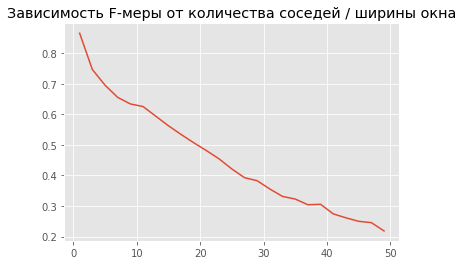

In [19]:
plt.title('Зависимость F-меры от количества соседей / ширины окна')
plt.plot(list(grid_cv.cv_results_['param_n_neighbors']), grid_cv.cv_results_['mean_test_score'])

## 2. OneHot-преобразование

Посмотрим, какие результаты даст OneHot-преобразование, где каждый класс заменяется на массив элементов.

### 2.1. От числа соседей

In [20]:
grid_param = {
    "n_neighbors": [1, 3, 5, 7, 9],
    "distance_name": ["euclidean", "manhattan", "chebyshev"],
    "kernel_name": ["uniform", "triangular", "epanechnikov", "quartic", "triweight",
                    "tricube", "gaussian", "cosine", "logistic", "sigmoid"],
    "encoding": ["hot"],
    "win_type": ["variable"]
}

In [21]:
grid_cv = model_selection.GridSearchCV(
    MyKnn(),
    grid_param,
    scoring=scorer,
    cv=LeaveOneOut()
)

In [22]:
%time grid_cv.fit(X, Y)

CPU times: user 6min 13s, sys: 308 ms, total: 6min 13s
Wall time: 6min 13s


GridSearchCV(cv=LeaveOneOut(), error_score=nan,
             estimator=MyKnn(distance_name='euclidean', encoding='label',
                             kernel_name='cosine', n_neighbors=5,
                             win_type='fixed'),
             iid='deprecated', n_jobs=None,
             param_grid={'distance_name': ['euclidean', 'manhattan',
                                           'chebyshev'],
                         'encoding': ['hot'],
                         'kernel_name': ['uniform', 'triangular',
                                         'epanechnikov', 'quartic', 'triweight',
                                         'tricube', 'gaussian', 'cosine',
                                         'logistic', 'sigmoid'],
                         'n_neighbors': [1, 3, 5, 7, 9],
                         'win_type': ['variable']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(f1_score, average=macro), verbose=0)

In [23]:
variable_params = grid_cv.best_params_
variable_score = grid_cv.best_score_ 
print(f'Лучшие параметры для OneHot от числа соседей: {variable_params}')
print(f'F1-мера с лучшими параметрами:                {variable_score:.2%}')

Лучшие параметры для OneHot от числа соседей: {'distance_name': 'euclidean', 'encoding': 'hot', 'kernel_name': 'triangular', 'n_neighbors': 7, 'win_type': 'variable'}
F1-мера с лучшими параметрами:                87.57%


### 2.2. От ширины окна

In [24]:
grid_param = {
    "n_neighbors": np.arange(0.05, 0.5, 0.05),
    "distance_name": ["euclidean", "manhattan", "chebyshev"],
    "kernel_name": ["uniform", "triangular", "epanechnikov", "quartic", "triweight",
                    "tricube", "gaussian", "cosine", "logistic", "sigmoid"],
    "encoding": ["hot"],
    "win_type": ["fixed"]
}

In [25]:
grid_cv = model_selection.GridSearchCV(
    MyKnn(),
    grid_param,
    scoring=scorer,
    cv=LeaveOneOut()
)

In [26]:
%time grid_cv.fit(X, Y)

CPU times: user 11min 11s, sys: 692 ms, total: 11min 12s
Wall time: 11min 12s


GridSearchCV(cv=LeaveOneOut(), error_score=nan,
             estimator=MyKnn(distance_name='euclidean', encoding='label',
                             kernel_name='cosine', n_neighbors=5,
                             win_type='fixed'),
             iid='deprecated', n_jobs=None,
             param_grid={'distance_name': ['euclidean', 'manhattan',
                                           'chebyshev'],
                         'encoding': ['hot'],
                         'kernel_name': ['uniform', 'triangular',
                                         'epanechnikov', 'quartic', 'triweight',
                                         'tricube', 'gaussian', 'cosine',
                                         'logistic', 'sigmoid'],
                         'n_neighbors': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45]),
                         'win_type': ['fixed']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(f

In [27]:
fixed_params = grid_cv.best_params_
fixed_score = grid_cv.best_score_
print(f'Лучшие параметры для OneHot от ширины окна: {fixed_params}')
print(f'F1-мера с лучшими параметрами:              {fixed_score:.2%}')

Лучшие параметры для OneHot от ширины окна: {'distance_name': 'chebyshev', 'encoding': 'hot', 'kernel_name': 'logistic', 'n_neighbors': 0.4, 'win_type': 'fixed'}
F1-мера с лучшими параметрами:              63.14%


### 2.3. Лучшие параметры

In [28]:
knn = MyKnn()

if variable_score > fixed_score:
    knn.set_params(**variable_params)
    grid_param = {'n_neighbors': np.arange(1, 50, 2)}
else:
    knn.set_params(**fixed_params)
    grid_param = {'n_neighbors': np.arange(0.02, 0.98, 0.02)}

In [29]:
grid_cv = model_selection.GridSearchCV(
    knn,
    grid_param,
    scoring=scorer,
    cv=LeaveOneOut()
)

In [30]:
%time grid_cv.fit(X, Y)

CPU times: user 1min 1s, sys: 51.9 ms, total: 1min 1s
Wall time: 1min 1s


GridSearchCV(cv=LeaveOneOut(), error_score=nan,
             estimator=MyKnn(distance_name='euclidean', encoding='hot',
                             kernel_name='triangular', n_neighbors=7,
                             win_type='variable'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39, 41, 43, 45, 47, 49])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(f1_score, average=macro), verbose=0)

In [31]:
best_params = grid_cv.best_params_
best_score = grid_cv.best_score_
print(f'Лучшие параметры для OneHot:   {best_params}')
print(f'F1-мера с лучшими параметрами: {best_score:.2%}')

Лучшие параметры для OneHot:   {'n_neighbors': 7}
F1-мера с лучшими параметрами: 87.57%


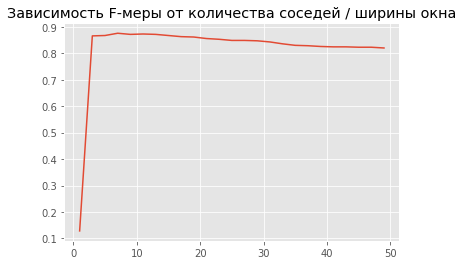

In [32]:
plt.title('Зависимость F-меры от количества соседей / ширины окна')
plt.plot(list(grid_cv.cv_results_['param_n_neighbors']), grid_cv.cv_results_['mean_test_score'])